In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import cgs as cgs
from scipy import interpolate
import dwarf_model as dw_model

using cgs py


In [2]:
fpath = '/home/emerick/Research/dwarfs/flash_runs/carina_final/'

mass_adiabatic = np.genfromtxt(fpath + "../carina_adiabatic/mass_evolution_0-300.dat",names=True)


In [3]:
def solvr(x,t,A):
    return [x[1],A/x[0]]

In [4]:
rho_i = 1.0 * cgs.mp * 1.31
rho_h = 1.0E-4 * cgs.mp * 0.62
v = 200.0E5
r_o = 400.*cgs.pc

A = rho_h * v*v * 0.5 / rho_i

In [5]:
t = np.linspace(0.0,500.0,1000.0)*cgs.Myr
r = integrate.odeint(solvr, [r_o,0], t, args=(A,))

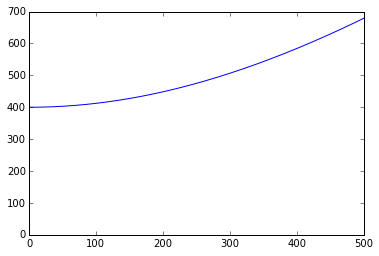

In [6]:
plt.plot(t/cgs.Myr,r/cgs.pc)

In [7]:
from initial_conditions import ic_list as icl

Loading IC for  Leo_T_burkert
Loading IC for  Leo_T
MUST SET A 'potential_type'
Loading IC for  Sextans_test
MUST SET A 'potential_type'
Loading IC for  Leo_T_obs
Assuming primordial neutral for dwarf mu = 1.31
Assuming primordial ionized for halo mu = 0.6
If M200 or n_o are not set, they will be solved for
using the profile choice
Loading IC for  CarinaMidMed
If M200 or n_o are not set, they will be solved for
using the profile choice
Loading IC for  Leo_T_solve_burkert
Assuming primordial neutral for dwarf mu = 1.31
Assuming primordial ionized for halo mu = 0.6
If M200 or n_o are not set, they will be solved for
using the profile choice
Loading IC for  Leo_test
MUST SET A 'potential_type'
Loaded IC's for  7  dwarf galaxies


In [8]:
carina = icl.ic_object_dict['CarinaMidMed']

In [9]:
### now for something entirely different ###

def f(y, t, rho_halo, v, rho_gas, rho_gas_o):
    # y contains mass as y[0] and radius as y[1]
    Mi = y[0]
    Ri = y[1]
    
    
    num = 1.0
    if Mi <= 0 or Ri <=0:
        Ri = 0.0
        num = 0.0
    rdot = -0.5 * (4.0/3.0)*(rho_halo/rho_gas_o)**0.5 * v
    #c_sound = ((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5
    #rdot = -c_sound
    
    mdot = 4.0*np.pi*Ri**2 * rho_gas(Ri) * rdot
  

    
    return [num*mdot, num*rdot]

def f_method2(y, t, rho_halo, v, rho_gas, rho_gas_o):
    # y contains mass as y[0] and radius as y[1]
    Mi = y[0]
    Ri = y[1]
    
    
    num = 1.0
    if Mi <= 0 or Ri <=0:
        Ri = 0.0
        num = 0.0
        
    vshock = (4./3.)*(rho_halo/rho_gas_o)**0.5 * v
    tau_rps = 2.0*Ri/ vshock
    mdot = -Mi / tau_rps      
    rdot = mdot / (4.0*np.pi*Ri**2 * rho_gas(Ri))
        

   # rdot = -0.5 * (4.0/3.0)*(rho_halo/rho_gas_o)**0.5 * v
    #c_sound = ((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5
    #rdot = -c_sound
    
    #mdot = 4.0*np.pi*Ri**2 * rho_gas(Ri) * rdot
  

    
    return [num*mdot, num*rdot]
    
def KH(y, t, rho_halo, v, rho_gas):
    Mi = y[0]
    Ri = y[1]
    
    Mdot = -np.pi * Ri**2 * rho_halo * v
    Rdot = Mdot / (4.0*np.pi*Ri**2 * rho_gas(Ri))
    
    return [Mdot,Rdot]

def KH_t(y, t, rho_halo, v, rho_gas):
    Mi = y[0]
    Ri = y[1]
    
    Mdot = -np.pi * Ri**2 * rho_halo(t) * v(t)
    Rdot = Mdot / (4.0*np.pi*Ri**2 * rho_gas(Ri))
    
    return [Mdot,Rdot]

In [10]:
print carina.ic.keys()
print carina.ic['RM'] / cgs.pc
print (carina.ic['RM']/((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5)/cgs.Myr
c_sound = ((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5
print c_sound / 1.0E5

['r_s', 'T_dwarf', 'b', 'mu_halo', 'RM', 'M200', 'n_halo', 'potential_type', 'M_DM', 'mu_dwarf', 'n_o', 'r_DM', 'c', 'T_halo', 'rho_crit']
423.12007563
40.3727153889
10.2478293046


In [11]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 200.0E5
R_o = carina.ic['RM']
print "M200 = %4.4e"%(carina.ic['M200']/cgs.Msun)
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,600,100.0)*cgs.Myr

soln = integrate.odeint(f, [M_o,R_o],t, args=(rho_halo, v, carina.find_density_profile,carina.find_density_profile(0.0)))
soln2 = integrate.odeint(f_method2, [M_o,R_o],t, args=(rho_halo, v, carina.find_density_profile,carina.find_density_profile(0.0)))



M200 = 3.3885e+08
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.


(0, 500)

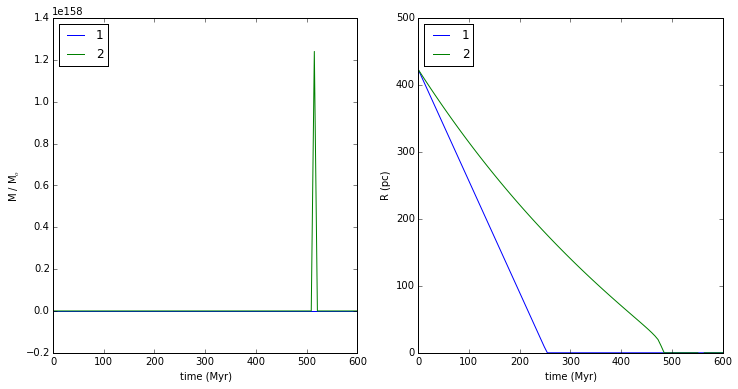

In [12]:
# plotting the ram pressure stripping evolution
fig = plt.figure(figsize=[12,6])
t = np.linspace(0.0,600,100.0)*cgs.Myr

M = soln[:,0]; R = soln[:,1]
M2 = soln2[:,0]; R2 = soln2[:,1]

select = M > 0
M = M[select]; t = t[select]; R = R[select]

ax1 = fig.add_subplot(1,2,1)
ax1.plot(t/cgs.Myr, M/M[0],label='1')
ax1.plot(t/cgs.Myr, M2/M2[0],label='2')
ax1.legend(loc='best'); ax1.set_xlabel('time (Myr)'); ax1.set_ylabel(r'M / M$_{o}$')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(t/cgs.Myr, R/cgs.pc, label='1')
ax2.plot(t/cgs.Myr, R2/cgs.pc, label='2')
ax2.legend(loc='best'); ax2.set_xlabel('time (Myr)'); ax2.set_ylabel(r'R (pc)')
ax2.set_ylim(0,500)


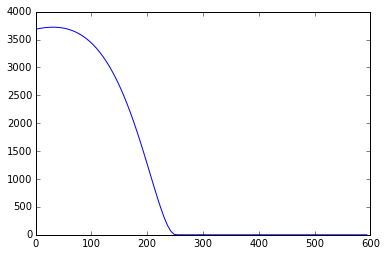

In [13]:
plt.plot(t[0:-1]/cgs.Myr, -np.diff(M/cgs.Msun)/np.diff(t/cgs.Myr))

(0, 500)

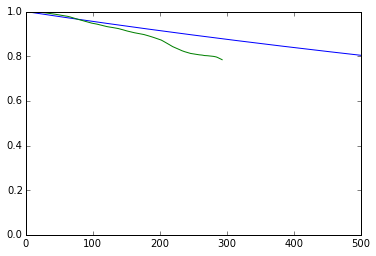

In [14]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 200.0E5
R_o = carina.ic['RM']
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,1200.0,1000.0)*cgs.Myr

soln = integrate.odeint(KH, [M_o,R_o],t, args=(rho_halo, v, carina.find_density_profile,))
M_KH = soln[:,0]; R_KH = soln[:,1]
plt.plot(t/cgs.Myr,M_KH/(M_KH[0]))
plt.plot(mass_adiabatic['t'], mass_adiabatic['m']/mass_adiabatic['m'][0])
plt.ylim(0,1)
plt.xlim(0,500)

In [15]:
carina_orbit = np.genfromtxt("./../orbits/carina_orbit_tab.dat")
t_orbit = carina_orbit[:,0] * cgs.Myr
v_orbit = carina_orbit[:,2] * 1.0E5

1.31206437896e+39
1.312806e+39 1.30561213102e+21
[  0.00000000e+00   3.79061862e+13] 3.79061861862e+13


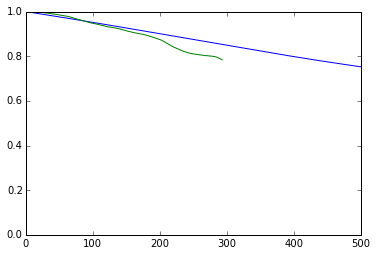

In [16]:

def rho_halo_func(t):
    rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
    return rho_halo # constant density

velocity_func = interpolate.UnivariateSpline(t_orbit, v_orbit,k=3)     # cubic spline 

R_o = carina.ic['RM']
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,1200.0,1000.0)*cgs.Myr

soln = integrate.odeint(KH_t, [M_o,R_o],t, args=(rho_halo_func, velocity_func, carina.find_density_profile,))
M_KH = soln[:,0]; R_KH = soln[:,1]
plt.plot(t/cgs.Myr,M_KH/(M_KH[0]))
plt.plot(mass_adiabatic['t'], mass_adiabatic['m']/mass_adiabatic['m'][0])
plt.ylim(0,1)
plt.xlim(0,500)
soln_test = integrate.odeint(KH_t, [M_o,R_o], np.array([t[0],t[1]]), args=(rho_halo_func, velocity_func, carina.find_density_profile,))
print soln_test[1,0]
print M_o, R_o
print t[0:2], t[1]

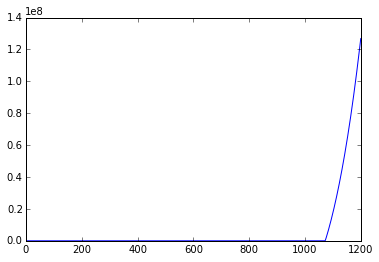

In [17]:
plt.plot(t/cgs.Myr, R_KH/cgs.pc)

[]

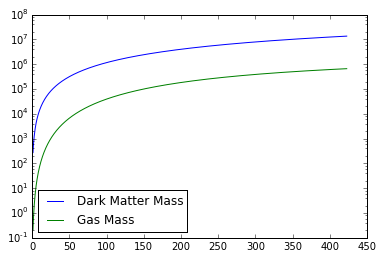

In [18]:
r  = np.linspace(1.0*cgs.pc,R_o,1000)
rho_gas = carina.find_density_profile(r)
rho_DM  = carina.DM_density(r)
integrand = lambda x: x*x*carina.DM_density(x)
gas = lambda x: x*x*carina.find_density_profile(x)
M_DM = np.zeros(np.size(r)-1)
M_gas = np.zeros(np.size(r)-1)
for i in np.arange(1,np.size(r)):
    M_DM[i-1] = 4.0*np.pi* integrate.quad(integrand, 0.0, r[i])[0]
    M_gas[i-1] = 4.0*np.pi* integrate.quad(gas, 0.0,r[i])[0]
plt.plot(r[:-1]/cgs.pc,M_DM/cgs.Msun,label='Dark Matter Mass')
plt.plot(r[:-1]/cgs.pc,M_gas/cgs.Msun,label='Gas Mass')
plt.legend(loc='best')
plt.semilogy()

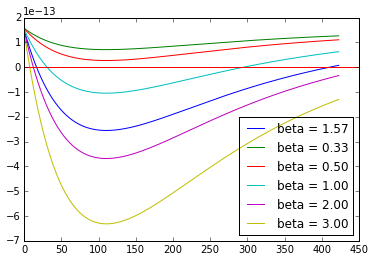

In [19]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 300.0E5

for beta in np.array([np.pi/2.0,1.0/3.0,0.5,1.0,2.0,3.0]):
    RHS = (M_DM + M_gas) * rho_gas[:-1] / r[:-1] * cgs.G * beta
    LHS = rho_halo * v*v
    RPS = LHS - RHS
    plt.plot(r[:-1]/cgs.pc,RPS,label='beta = %.2f'%(beta))
    
plt.legend(loc='best')
plt.plot(plt.xlim(),[0,0],color='red')

In [20]:
print np.where(np.abs(r/cgs.pc -300.16) < 1)
print (M_gas[-1] - M_gas[707])/cgs.Msun  /(M_gas[-1]/cgs.Msun)



(array([706, 707, 708, 709, 710]),)
0.413841166851


TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

TypeError: _KH_evolution() takes exactly 5 arguments (6 given)

IndexError: index 1 is out of bounds for axis 0 with size 1